Сервис "МиФаСоль" расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. имеется датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

шаги выпольнения работы:

- [ ] загрузка и ознакомление с данными,
- [ ] предварительная обработка,
    - [ ] устранения пропусков,
    - [ ] проверить наличия явных и неявных дубликатов,
    - [ ] переоброзовать типы данных
- [ ] полноценный разведочный анализ,
- [ ] разработка новых синтетических признаков,
- [ ] проверка на мультиколлинеарность,
- [ ] отбор финального набора обучающих признаков,
- [ ] выбор и обучение моделей,
- [ ] итоговая оценка качества предсказания лучшей модели,
- [ ] анализ важности ее признаков.

# загрузка и ознакомление с данными

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
    
)
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.metrics import accuracy_score , confusion_matrix, f1_score, ConfusionMatrixDisplay, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
data = pd.read_csv('kaggle_music_genre_train.csv')
data.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

Описание полей данных
+ 'instance_id' -Уникальный идентификатор трека
+ 'track_name' - Название трека
+ 'acousticness' - Мера уверенности от 0,0 до 1,0 в том, что трек является акустическим. 1,0 означает высокую степень уверенности в том, что трек является акустическим.
+ 'danceability' - Танцевальность описывает, насколько трек подходит для танцев, основываясь на сочетании музыкальных элементов, включая темп, стабильность ритма, силу ударов и общую регулярность. Значение 0,0 означает наименьшую танцевальность, а 1,0 - наибольшую танцевальность.
+ 'duration_ms' - Продолжительность трека в миллисекундах.
+ 'energy' - Энергия это показатель от 0,0 до 1,0, представляющий собой меру интенсивности и активности. Как правило, энергичные композиции ощущаются как быстрые, громкие и шумные. Например, дэт-метал обладает высокой энергией, в то время как прелюдия Баха имеет низкую оценку этого параметра
+ 'instrumentalness' - Определяет, содержит ли трек вокал. Звуки "Ooh" и "aah" в данном контексте рассматриваются как инструментальные. Рэп или разговорные треки явно являются "вокальными". Чем ближе значение инструментальности к 1,0, тем больше вероятность того, что трек не содержит вокала
+ 'key' - базовый ключ (нота) произведения
+ 'liveness' - Определяет присутствие аудитории в записи. Более высокие значения liveness означают увеличение вероятности того, что трек был исполнен вживую. Значение выше 0,8 обеспечивает высокую вероятность того, что трек исполняется вживую
+ 'loudness' - Общая громкость трека в децибелах (дБ)
+ 'mode' - Указывает на модальность (мажорную или минорную) трека
+ 'speechiness' - Речевой характер определяет наличие в треке разговорной речи. Чем более исключительно речевой характер носит запись (например, ток-шоу, аудиокнига, поэзия), тем ближе значение атрибута к 1,0. Значения выше 0,66 характеризуют треки, которые, вероятно, полностью состоят из разговорной речи. Значения от 0,33 до 0,66 характеризуют треки, которые могут содержать как музыку, так и речь, как в виде фрагментов, так и в виде слоев, включая такие случаи, как рэп-музыка. Значения ниже 0,33, скорее всего, представляют музыку и другие неречевые треки.
+ 'tempo' - Темп трека в ударах в минуту (BPM). В музыкальной терминологии темп представляет собой скорость или темп данного произведения и напрямую зависит от средней продолжительности тактов
+ 'obtained_date' - дата загрузки в сервис
+ 'valence' - Показатель от 0,0 до 1,0, характеризующий музыкальный позитив, передаваемый треком. Композиции с высокой валентностью звучат более позитивно (например, радостно, весело, эйфорично), а композиции с низкой валентностью - более негативно (например, грустно, депрессивно, сердито)
+ 'music_genre' - Музыкальный жанр трека

# предварительная обработка

## обработка пропусков

In [4]:
data.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

в данных существуют пропуски а именно в столбцах key, mode, tempo.

In [5]:
data[data['key'].isna()].head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
26,87453.0,"Serenade in B flat, K.361 ""Gran partita"": 3. A...",0.9910,0.154,-1.0,0.0384,0.902000,NaN,0.109,-26.909,Major,0.0405,68.199,4-Apr,0.0393,Classical
49,87796.0,Star67,0.7470,0.478,294973.0,0.3950,0.000005,NaN,0.264,-7.917,Major,0.2130,74.515,3-Apr,0.1700,Hip-Hop
60,69398.0,Sleep On The Floor,0.2490,0.389,211851.0,0.4310,0.000000,NaN,0.130,-8.061,Major,0.0344,142.140,4-Apr,0.2750,Rock
75,20134.0,Rogue,0.0145,0.580,201694.0,0.7200,0.598000,NaN,0.281,-5.541,Major,0.0638,143.816,4-Apr,0.1600,Electronic
107,69505.0,Party Song,0.1560,0.563,191760.0,0.8970,0.000000,NaN,0.352,-4.996,Major,0.2130,157.803,4-Apr,0.7790,Country


In [6]:
data[data['mode'].isna()].head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
96,63867.0,"Clarinet Concerto No. 1 in F Minor, Op. 73, J....",0.973000,0.416,401000.0,0.0735,0.710000,F,0.0781,-20.723,NaN,0.0411,112.006,4-Apr,0.222,Classical
129,75913.0,"Concerto for Viola d'amore, Lute, Strings and ...",0.926000,0.495,-1.0,0.1110,0.120000,C#,0.0772,-18.591,NaN,0.0506,78.772,4-Apr,0.436,Classical
131,64391.0,She Keeps The Home Fires Burning,0.526000,0.731,236173.0,0.6080,0.000000,G,0.1260,-10.690,NaN,0.0267,126.263,4-Apr,0.745,Country
292,37649.0,Ven - Continuous Mix,0.000216,0.555,50472.0,0.9530,0.059400,E,0.8180,-4.411,NaN,0.1090,114.885,4-Apr,0.303,Electronic
326,43825.0,Wicked As It Seems,0.287000,0.689,285263.0,0.6200,0.000002,G,0.0368,-10.601,NaN,0.0339,110.860,4-Apr,0.962,Blues


In [7]:
data[data['tempo'].isna()].head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
63,45966.0,Back Door Man,0.287000,0.476,212427.0,0.612,0.000252,A,0.0877,-7.010,Major,0.0335,NaN,4-Apr,0.909,Rock
85,90217.0,familia,0.000059,0.489,269000.0,0.947,0.000000,C#,0.1130,-3.925,Minor,0.0419,NaN,4-Apr,0.517,Anime
114,79170.0,Poor Johnny,0.348000,0.698,362267.0,0.800,0.000087,B,0.4430,-3.091,Minor,0.0284,NaN,4-Apr,0.654,Blues
138,39716.0,Set Free (feat. Yael),0.008340,0.776,191210.0,0.783,0.044900,C,0.0377,-3.595,Major,0.0374,NaN,4-Apr,0.943,Electronic
145,48590.0,Running Away,0.001100,0.608,178440.0,0.801,0.000008,A,0.2230,-5.452,Minor,0.0376,NaN,3-Apr,0.544,Alternative


нет возьможности популнить логично пополнить пропусков так что нужно их удалить.

In [8]:
data = data.dropna()

In [9]:
data = data.reset_index(drop=True)

In [10]:
data.isna().sum()

instance_id         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
music_genre         0
dtype: int64

## проверить наличия явных и неявных дубликатов

In [11]:
data.duplicated().sum()

0

в данных отсутсвуют явные дубликаты.

In [12]:
data['instance_id'].duplicated().sum()

0

In [13]:
data['track_name'].duplicated().sum()

1525

In [14]:
data.duplicated(['track_name', 'key', 'mode', 'tempo', 'energy', 'loudness', 'obtained_date']).sum()

589

замечаем наличия неявных дубликатов, нужно их удалить.

In [15]:
data = data.drop_duplicates(['track_name', 'key', 'mode', 'tempo', 'energy', 'loudness', 'obtained_date'])
data = data.reset_index(drop=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18165 entries, 0 to 18164
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       18165 non-null  float64
 1   track_name        18165 non-null  object 
 2   acousticness      18165 non-null  float64
 3   danceability      18165 non-null  float64
 4   duration_ms       18165 non-null  float64
 5   energy            18165 non-null  float64
 6   instrumentalness  18165 non-null  float64
 7   key               18165 non-null  object 
 8   liveness          18165 non-null  float64
 9   loudness          18165 non-null  float64
 10  mode              18165 non-null  object 
 11  speechiness       18165 non-null  float64
 12  tempo             18165 non-null  float64
 13  obtained_date     18165 non-null  object 
 14  valence           18165 non-null  float64
 15  music_genre       18165 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

## переоброзовать типы данных

 instance_id, obtained_date и track_name будут удалены так как они не как не помагают модели, так что не надо переобразовать их типы.

In [17]:
data['duration_ms'] = data['duration_ms'].astype('int')

In [18]:
data['music_genre'].unique()

array(['Country', 'Rock', 'Alternative', 'Hip-Hop', 'Blues', 'Jazz',
       'Electronic', 'Anime', 'Rap', 'Classical'], dtype=object)

In [19]:
data['key'].unique()

array(['D', 'A', 'E', 'G#', 'C', 'D#', 'A#', 'F', 'F#', 'G', 'C#', 'B'],
      dtype=object)

In [20]:
data['mode'].unique()

array(['Major', 'Minor'], dtype=object)

In [21]:
data['obtained_date'].unique()

array(['4-Apr', '3-Apr', '5-Apr', '1-Apr'], dtype=object)

In [22]:
data['acousticness'].describe()

count    18165.000000
mean         0.277775
std          0.323681
min          0.000000
25%          0.015300
50%          0.123000
75%          0.477000
max          0.996000
Name: acousticness, dtype: float64

In [23]:
data['danceability'].describe()

count    18165.000000
mean         0.560337
std          0.172116
min          0.060000
25%          0.449000
50%          0.568000
75%          0.681000
max          0.978000
Name: danceability, dtype: float64

In [24]:
data['duration_ms'].describe()

count    1.816500e+04
mean     2.212424e+05
std      1.281687e+05
min     -1.000000e+00
25%      1.774930e+05
50%      2.198270e+05
75%      2.670190e+05
max      4.497994e+06
Name: duration_ms, dtype: float64

замечаем анумалии в duration_ms

In [25]:
data[data['duration_ms']==-1]

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
13,73565.0,Iwanakutemo Tsutawaru Arewa Sukoshi Usoda - Al...,0.11000,0.470,-1,0.6410,0.000000,F#,0.1550,-7.454,Major,0.0658,86.387,4-Apr,0.638,Anime
34,76827.0,Flodgin,0.08480,0.748,-1,0.7120,0.000000,D,0.1320,-5.651,Major,0.1430,140.055,4-Apr,0.180,Rap
48,43888.0,Things My Father Said,0.05400,0.482,-1,0.6270,0.000003,D,0.1110,-5.779,Major,0.0300,95.903,4-Apr,0.170,Alternative
53,39574.0,"Fidelio, Op. 72, Act I: Ha! Welch ein Augenbli...",0.90900,0.374,-1,0.2270,0.000069,A#,0.6860,-18.719,Major,0.0579,78.236,4-Apr,0.264,Classical
57,42479.0,American Grown,0.04810,0.615,-1,0.7790,0.000000,C,0.2300,-9.577,Major,0.0832,147.987,4-Apr,0.899,Country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18126,51087.0,Bachianas brasileiras No. 7: III. Toccata: Des...,0.90900,0.283,-1,0.1330,0.800000,B,0.0927,-25.586,Minor,0.0412,116.376,4-Apr,0.177,Classical
18134,48460.0,Airborne - MUST DIE! Remix,0.00298,0.450,-1,0.9150,0.446000,F,0.7710,-1.404,Minor,0.2360,137.948,4-Apr,0.156,Electronic
18138,23677.0,"Idomeneo, TrV 262, Act I (After W.A. Mozart): ...",0.98200,0.372,-1,0.1590,0.000001,G,0.1650,-21.129,Major,0.0364,135.617,3-Apr,0.512,Classical
18139,89832.0,I Want My Milk (I Want it Now),0.96600,0.638,-1,0.0689,0.000001,E,0.1020,-16.222,Major,0.0659,120.160,3-Apr,0.695,Blues


скорее всего duration_ms = -1 это пропуск, но так как пропусков много то удалят их нельзя. лучше не учитывать данных duration_ms в обучения модели.

In [26]:
data['energy'].describe()

count    18165.000000
mean         0.623729
std          0.252876
min          0.001010
25%          0.466000
50%          0.665000
75%          0.831000
max          0.999000
Name: energy, dtype: float64

In [27]:
data['instrumentalness'].describe()

count    18165.000000
mean         0.164010
std          0.309756
min          0.000000
25%          0.000000
50%          0.000164
75%          0.097000
max          0.996000
Name: instrumentalness, dtype: float64

In [28]:
data['liveness'].describe()

count    18165.000000
mean         0.198934
std          0.167335
min          0.013600
25%          0.097300
50%          0.130000
75%          0.253000
max          1.000000
Name: liveness, dtype: float64

In [29]:
data['loudness'].describe()

count    18165.000000
mean        -8.603104
std          5.557507
min        -44.406000
25%        -10.327000
50%         -7.070000
75%         -5.058000
max          3.744000
Name: loudness, dtype: float64

In [30]:
data['speechiness'].describe()

count    18165.000000
mean         0.090356
std          0.096945
min          0.022300
25%          0.035600
50%          0.048700
75%          0.093400
max          0.932000
Name: speechiness, dtype: float64

In [31]:
data['tempo'].describe()

count    18165.000000
mean       120.979325
std         30.465294
min         34.765000
25%         95.948000
50%        120.013000
75%        141.966000
max        220.041000
Name: tempo, dtype: float64

In [32]:
data['valence'].describe()

count    18165.000000
mean         0.463970
std          0.244193
min          0.000000
25%          0.270000
50%          0.456000
75%          0.653000
max          0.992000
Name: valence, dtype: float64

все остальные типы данных соотвествуют.

# разведочный анализ

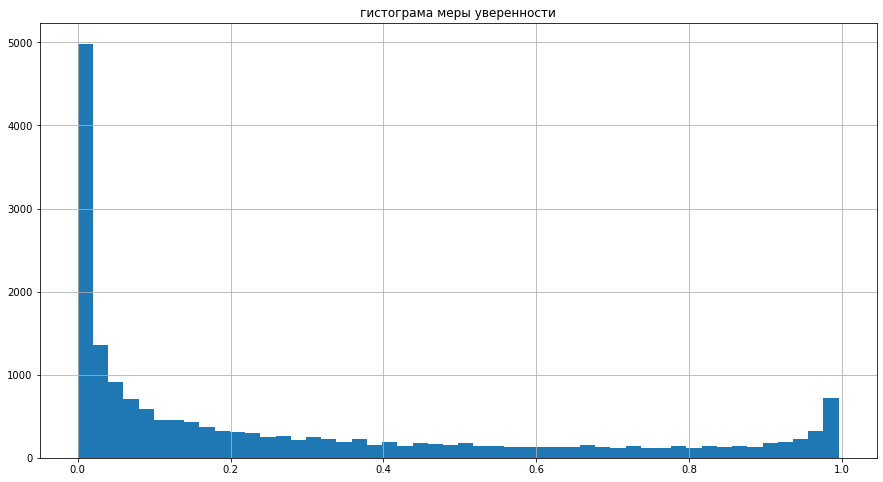

In [33]:
data['acousticness'].hist(bins=50, figsize=(15, 8));
plt.title('гистограма меры уверенности');

замечаем что большенство треков в датасете с нулевой acousticness

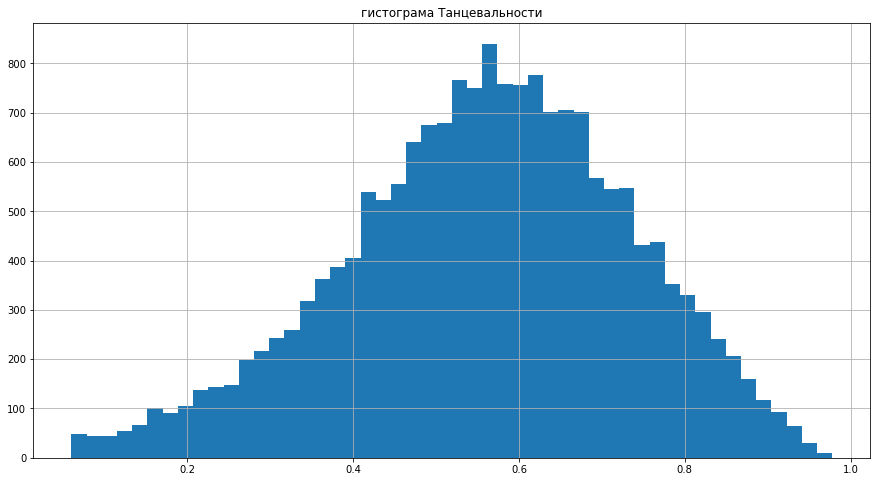

In [34]:
data['danceability'].hist(bins=50, figsize=(15, 8));
plt.title('гистограма Танцевальности');

замечаем что гистограма Танцевальности похоже на нармальное распределение

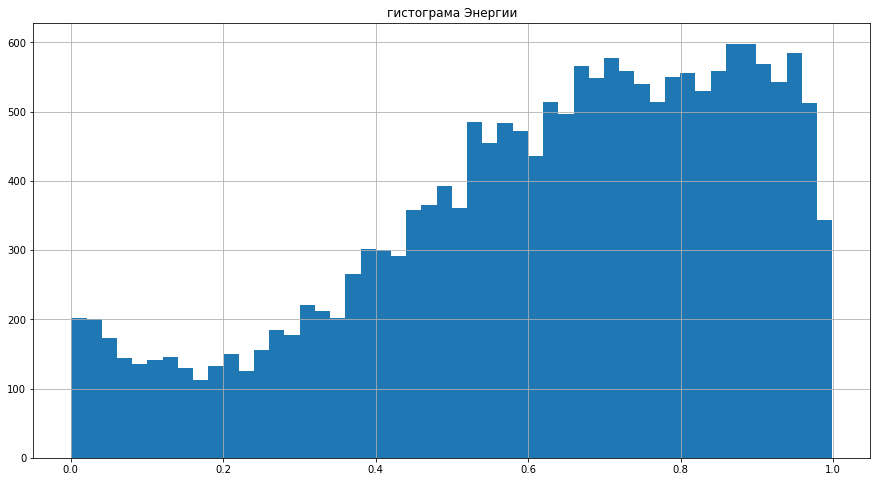

In [35]:
data['energy'].hist(bins=50, figsize=(15, 8));
plt.title('гистограма Энергии');

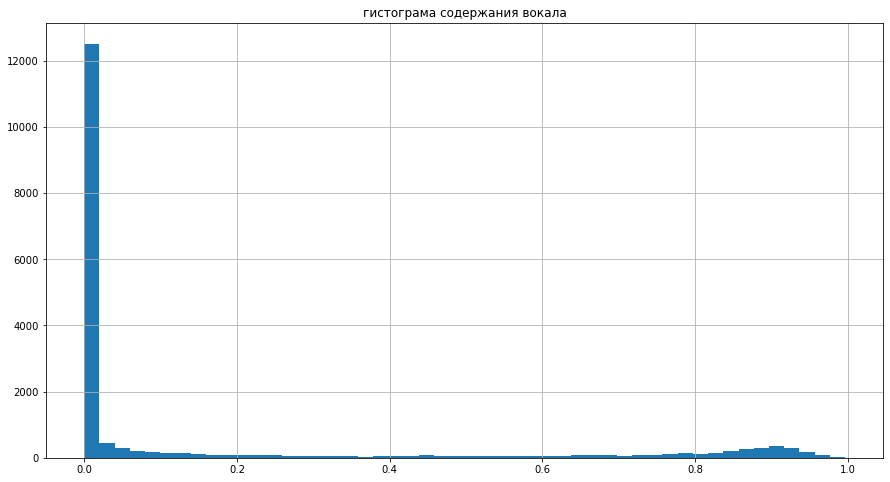

In [36]:
data['instrumentalness'].hist(bins=50, figsize=(15, 8));
plt.title('гистограма содержания вокала');

замечаем что большенство треков в датасете с нулевым содержанием вокала, на сколько, что можно не включать столбца instrumentalness в обучения модели

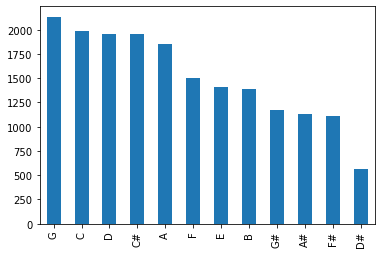

In [37]:
data['key'].value_counts().plot(kind='bar');

замечаем что меньшество треков в датасете испольнены в D# ключе

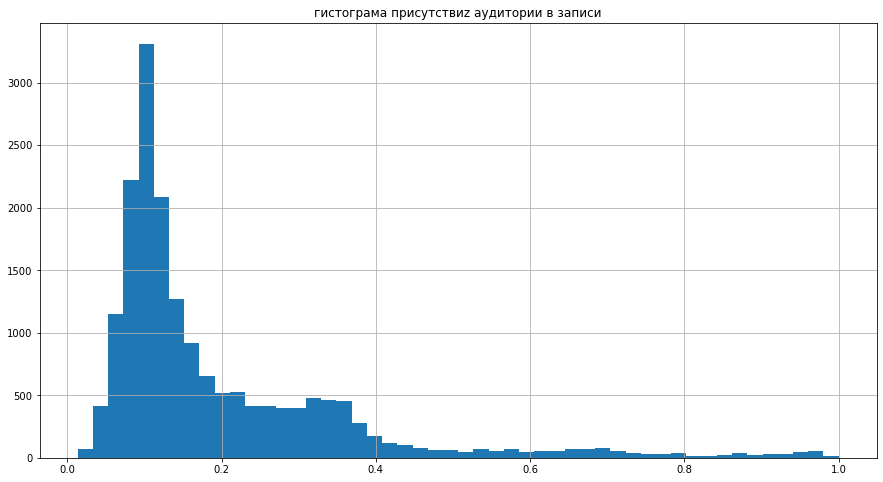

In [38]:
data['liveness'].hist(bins=50, figsize=(15, 8));
plt.title('гистограма присутствиz аудитории в записи');

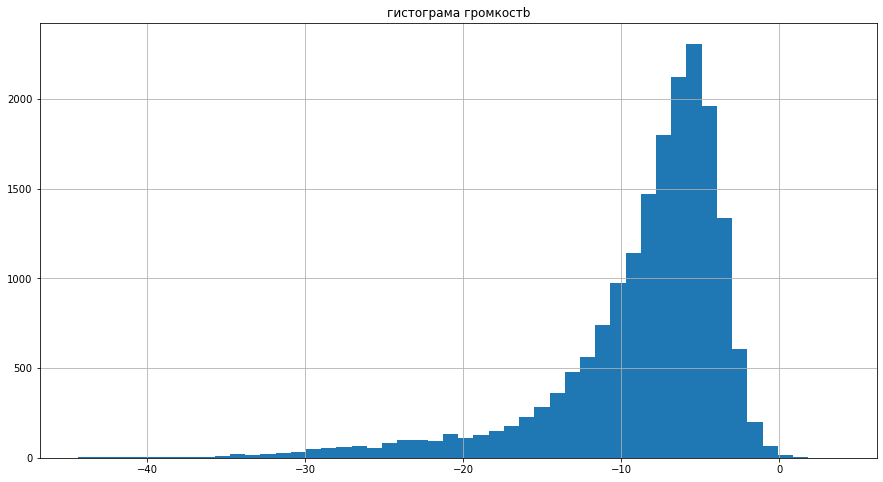

In [39]:
data['loudness'].hist(bins=50, figsize=(15, 8));
plt.title('гистограма громкостb');

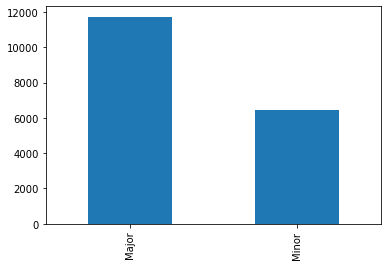

In [40]:
data['mode'].value_counts().plot(kind='bar');

замечаем что большество треков в датасете испольнены миноре

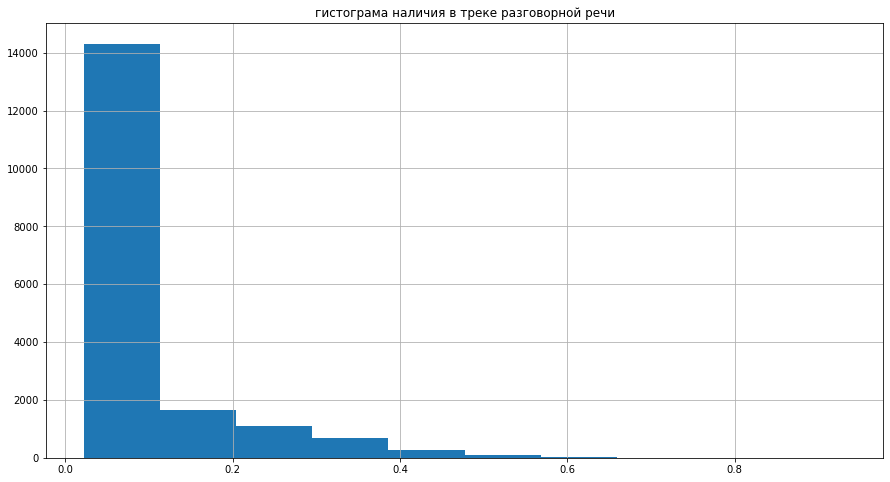

In [41]:
data['speechiness'].hist(bins=10, figsize=(15, 8));
plt.title('гистограма наличия в треке разговорной речи');

замечаем что большество треков в датасете без наличия в треке разговорной речи

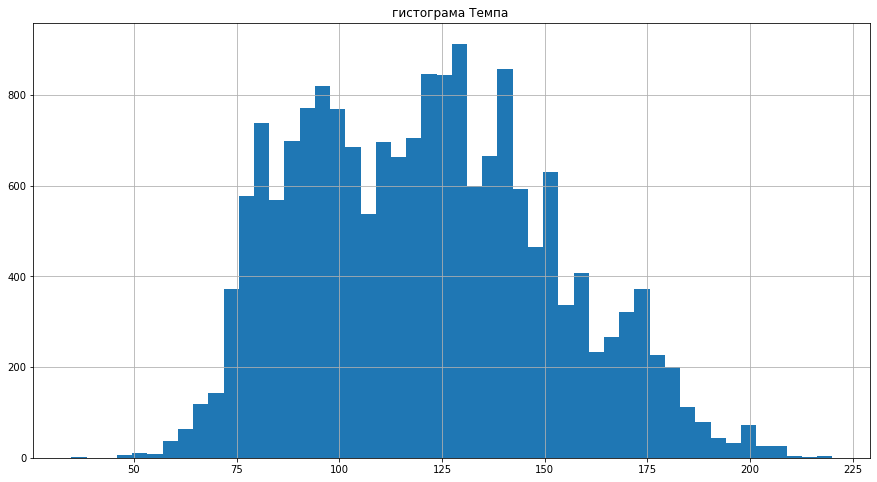

In [42]:
data['tempo'].hist(bins=50, figsize=(15, 8));
plt.title('гистограма Темпа ');

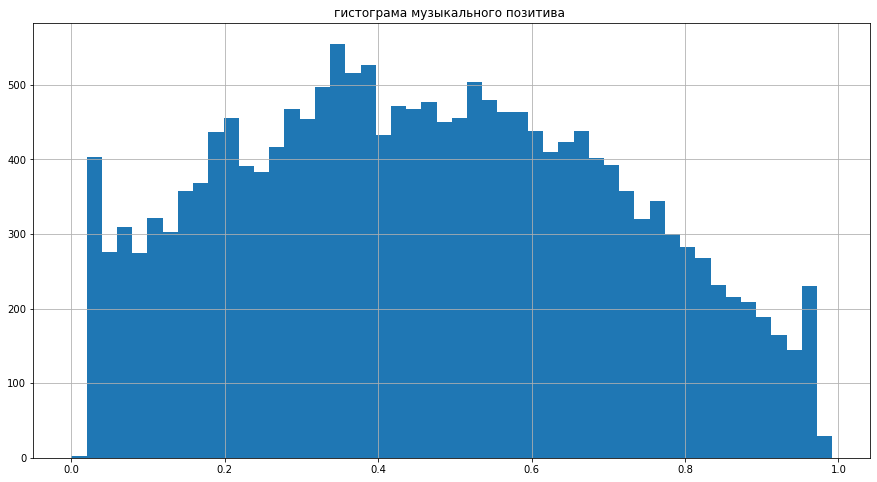

In [43]:
data['valence'].hist(bins=50, figsize=(15, 8));
plt.title('гистограма музыкального позитива ');

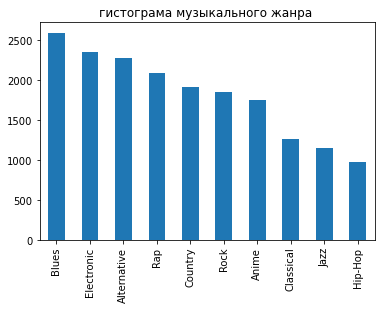

In [44]:
data['music_genre'].value_counts().plot(kind='bar'); 
plt.title('гистограма музыкального жанра ');

замечаем дисбаланс классов!

# проверка на мультиколлинеарность

In [45]:
data.corr()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
instance_id,1.000000,0.008015,-0.003751,-0.000690,-0.000023,0.013131,0.002343,-0.004044,-0.011820,-0.013492,-0.001519
acousticness,0.008015,1.000000,-0.277278,0.046611,-0.768023,0.319953,-0.092132,-0.701738,-0.146232,-0.219139,-0.227751
danceability,-0.003751,-0.277278,1.000000,-0.147165,0.190018,-0.254750,-0.079602,0.320752,0.256373,-0.056531,0.394929
duration_ms,-0.000690,0.046611,-0.147165,1.000000,-0.057272,0.140804,0.032868,-0.099986,-0.082079,-0.044273,-0.126941
energy,-0.000023,-0.768023,0.190018,-0.057272,1.000000,-0.322271,0.178149,0.822903,0.154089,0.252636,0.352416
instrumentalness,0.013131,0.319953,-0.254750,0.140804,-0.322271,1.000000,-0.065338,-0.483099,-0.174781,-0.098908,-0.261617
liveness,0.002343,-0.092132,-0.079602,0.032868,0.178149,-0.065338,1.000000,0.110082,0.098825,0.036799,0.036728
loudness,-0.004044,-0.701738,0.320752,-0.099986,0.822903,-0.483099,0.110082,1.000000,0.153210,0.223523,0.288890
speechiness,-0.011820,-0.146232,0.256373,-0.082079,0.154089,-0.174781,0.098825,0.153210,1.000000,0.070902,0.030633
tempo,-0.013492,-0.219139,-0.056531,-0.044273,0.252636,-0.098908,0.036799,0.223523,0.070902,1.000000,0.087825


замечаем что acousticness, energy и loudness сильно сорролирует между собой, поэтому нам следует рассмотреть возможность удаления хотя бы одной из переменных из полученной модели. попробуем удалить energy, потом energy и acousticness.

# разработка новых синтетических признаков

первое дело нужно избавиться от ненужных столбцов.

In [46]:
data = data.drop(['instance_id'], axis=1)
data = data.drop(['track_name'], axis=1)
data = data.drop(['acousticness'], axis=1)
data = data.drop(['loudness'], axis=1)

чтобы обучить класификатора нужно избавиться от катикорияльных переменных, а именно:key , mode , music_genre. для этого используем прямоe кодированиe потому-что оно подходить для всех класификаторов.

In [47]:
target = data['music_genre']
features = data.drop('music_genre', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25)

In [48]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(13623, 11)
(13623,)
(4542, 11)
(4542,)


In [49]:
#категориальные признаки для OHE Ridge
ohe_features_ridge = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_ridge)

['key', 'mode', 'obtained_date']


In [50]:
#численные признаки
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features

['danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'speechiness',
 'tempo',
 'valence']

In [51]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features_ridge])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[ohe_features_ridge])
# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features_ridge, axis=1)

# создаём скелер
# scaler = StandardScaler()
scaler = RobustScaler()
# # обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train[num_features] = scaler.fit_transform(features_train[num_features])

# смотрим на результат
features_train.head()

,danceability,duration_ms,energy,instrumentalness,liveness,speechiness,tempo,valence,key_A#,key_B,...,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor,obtained_date_3-Apr,obtained_date_4-Apr,obtained_date_5-Apr
4285,0.813853,-0.875159,-0.236439,-0.001681,-0.162496,0.287425,0.870661,0.217848,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
9692,-0.095238,-2.463796,0.709318,0.008697,0.441989,0.143713,-0.154767,0.196850,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11814,0.398268,-0.260265,-0.759388,-0.001681,-0.090998,-0.424294,-0.450023,0.262467,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3836,0.567100,-0.196711,-0.008345,-0.001681,-0.090998,0.485885,-0.106953,0.178478,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
9105,0.939394,-0.170673,0.239221,-0.001623,-0.273643,0.015398,-0.000935,0.530184,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [53]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[ohe_features_ridge])

features_test = features_test.drop(ohe_features_ridge, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
features_test[num_features] = scaler.transform(features_test[num_features])

# смотрим на результат
features_test.head()

,danceability,duration_ms,energy,instrumentalness,liveness,speechiness,tempo,valence,key_A#,key_B,...,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor,obtained_date_3-Apr,obtained_date_4-Apr,obtained_date_5-Apr
12483,-1.103896,0.545762,0.823366,-0.000301,1.351966,0.094098,1.320836,0.099738,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9267,0.398268,0.274174,-0.433936,-0.001681,0.123497,8.337040,-0.738041,0.769029,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
17979,-0.181818,-2.463796,-1.549374,9.484567,-0.090998,-0.179641,-0.260220,0.682415,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1485,0.229437,-0.313741,-0.336579,-0.001456,0.201495,0.590248,-0.868988,0.217848,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6351,0.424242,-0.784077,-0.497914,-0.001657,-0.373091,0.196749,-0.018452,0.824147,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [54]:
recall_scorer = make_scorer(accuracy_score)

### модель дерево решений 

In [55]:
# for i in range(1, 20):
#     model_DTC = DecisionTreeClassifier(max_depth=i, random_state=0, class_weight='balanced')
#     scores = cross_val_score(model_DTC, features_train, target_train, cv=20, scoring=recall_scorer) 
#     final_score = scores.mean()
#     print('Средняя оценка качества модели дерево решений при max_depth = ',i , ':', final_score)

In [56]:
# max_feat = [1, 2, 4, 6, 8, 10, 15, 20, 25, None]
# for i in max_feat:
#     model_DTC = DecisionTreeClassifier(max_depth=9, max_features=i, random_state=0, class_weight='balanced')
#     scores = cross_val_score(model_DTC, features_train, target_train, cv=20, scoring=recall_scorer) 
#     final_score = scores.mean()
#     print('Средняя оценка качества модели дерево решений при max_features = ',i , ':', final_score)

In [57]:
# for i in range(2, 20):
#     model_DTC = DecisionTreeClassifier(max_depth=9, max_features=15, max_leaf_nodes=i, random_state=0, class_weight='balanced')
#     scores = cross_val_score(model_DTC, features_train, target_train, cv=20, scoring=recall_scorer) 
#     final_score = scores.mean()
#     print('Средняя оценка качества модели дерево решений при max_leaf_nodes = ',i , ':', final_score)

### случайный лес

In [58]:
# for i in range(1, 20):
#     model_RFC = RandomForestClassifier(n_estimators=i, random_state=0, class_weight='balanced')
#     scores = cross_val_score(model_RFC, features_train, target_train, cv=20, scoring=recall_scorer) 
#     final_score = scores.mean()
#     print('Средняя оценка качества модели случайного леса при n_estimators = ',i , ':', final_score)

In [59]:
# for i in range(1, 20):
#     model_RFC = RandomForestClassifier(n_estimators=20, max_depth=i, random_state=0, class_weight='balanced')
#     scores = cross_val_score(model_RFC, features_train, target_train, cv=20, scoring=recall_scorer) 
#     final_score = scores.mean()
#     print('Средняя оценка качества модели случайного леса при max_depth = ',i , ':', final_score)

In [60]:
# for i in range(2, 20):
#     model_RFC = RandomForestClassifier(n_estimators=20, max_depth=17, max_leaf_nodes=i, random_state=0, class_weight='balanced')
#     scores = cross_val_score(model_RFC, features_train, target_train, cv=20, scoring=recall_scorer) 
#     final_score = scores.mean()
#     print('Средняя оценка качества модели случайного леса при max_leaf_nodes = ',i , ':', final_score)

### Логистическая регрессия

In [61]:
# for i in range(1, 20):
#     model_LG = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', max_iter=i*100)
#     scores = cross_val_score(model_LG, features_train, target_train, cv=20, scoring=recall_scorer)
#     final_score = scores.mean()
#     print('Средняя оценка качества модели логистической регрессии приmax_iter =', i*100, ':', final_score)

In [62]:
model = RandomForestClassifier(n_estimators=100, max_depth=17, random_state=0, class_weight='balanced')
model.fit(features_train, target_train)
predictions = model.predict(features_test) 
accuracy = accuracy_score(target_test, predictions) 
print(accuracy)

0.45310435931307796


In [63]:
target_train = data['music_genre']
features_train = data.drop('music_genre', axis=1) 

In [64]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features_ridge])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[ohe_features_ridge])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features_ridge, axis=1)

# создаём скелер
scaler = RobustScaler()

# # обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train[num_features] = scaler.fit_transform(features_train[num_features])

# смотрим на результат
features_train.head()

,danceability,duration_ms,energy,instrumentalness,liveness,speechiness,tempo,valence,key_A#,key_B,...,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor,obtained_date_3-Apr,obtained_date_4-Apr,obtained_date_5-Apr
0,0.439655,-0.415231,-0.860274,0.179753,-0.096339,-0.041522,-0.404820,-0.015666,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.500000,-0.365190,0.013699,-0.001167,-0.141297,-0.233564,-0.150854,0.216710,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.491379,-0.518051,0.380822,-0.001691,0.327553,5.576125,-0.848212,-0.292428,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.202586,0.403905,0.569863,-0.001658,1.252408,0.548443,-0.087053,1.331593,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.750000,-0.273596,-0.246575,-0.001672,0.295440,0.000000,-0.945695,0.331593,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


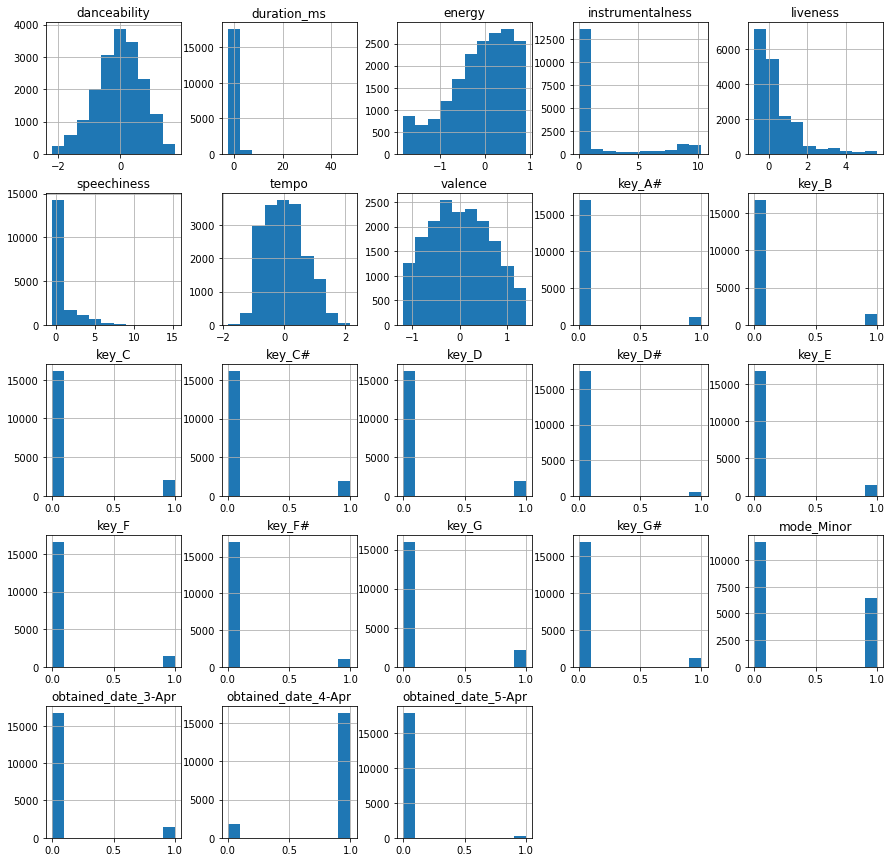

In [65]:
features_train.hist(figsize=(15, 15));

замечаем что лучшая модель является RandomForestClassifier с гиперпараметрами n_estimators=100, max_depth=17, class_weight='balanced' так что исспольуем ее.

In [66]:
model = RandomForestClassifier(n_estimators=100, max_depth=17, random_state=0, class_weight='balanced')
model.fit(features_train, target_train)
predictions = model.predict(features_test) 
accuracy = accuracy_score(target_test, predictions) 
print(accuracy)

0.9326287978863936


In [67]:
data_test = pd.read_csv('kaggle_music_genre_test.csv')

In [68]:
data_test = data_test.drop(['instance_id'], axis=1)
data_test = data_test.drop(['track_name'], axis=1)
data_test = data_test.drop('acousticness', axis=1) 
data_test = data_test.drop(['loudness'], axis=1)

In [69]:
data_test['tempo'] = data_test['tempo'].fillna(data_test['tempo'].median())

In [70]:
data_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(data_test[ohe_features_ridge])

data_test = data_test.drop(ohe_features_ridge, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
data_test[num_features] = scaler.transform(data_test[num_features])

# смотрим на результат
data_test.head()

C:\Users\firas\anaconda3\envs\reasearch_1\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,danceability,duration_ms,energy,instrumentalness,liveness,speechiness,tempo,valence,key_A#,key_B,...,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor,obtained_date_3-Apr,obtained_date_4-Apr,obtained_date_5-Apr
0,0.814655,-0.822264,0.038356,-0.001691,1.111111,5.316609,-0.644357,1.146214,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-1.344828,0.229352,-0.389041,0.084082,-0.289660,-0.333910,-0.904603,-0.360313,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.474138,0.716809,0.287671,-0.001691,-0.134875,2.998270,-0.652201,-0.114883,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.103448,-0.474421,0.230137,-0.001691,-0.051381,-0.006920,0.869942,0.412533,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.633621,-2.455465,-0.597260,0.150887,-0.594733,2.652249,-1.003586,-0.874674,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [71]:
predictions = model.predict(data_test) 

In [72]:
data_test = pd.read_csv('kaggle_music_genre_test.csv')

In [73]:
data_submit = pd.DataFrame({'instance_id':data_test['instance_id'],
                           'music_genre':predictions})

In [74]:
data_submit.to_csv('data_submit.csv', index=False)

# заключение

Сервис "МиФаСоль" расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. имеется датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.
задача выполнена, разработанная модель RandomForestClassifier с гиперпараметрами n_estimators=100, max_depth=17, class_weight='balanced' выдаля точность 0,46 на обучаюшую выборку

шаги выпольнения работы:

 - [x] загрузка и ознакомление с данными,
- [x] предварительная обработка,
    - [x] устранения пропусков,
    - [x] проверить наличия явных и неявных дубликатов,
    - [x] переоброзовать типы данных
- [x] полноценный разведочный анализ,
- [x] разработка новых синтетических признаков,
- [x] проверка на мультиколлинеарность,
- [x] отбор финального набора обучающих признаков,
- [x] выбор и обучение моделей,
- [x] итоговая оценка качества предсказания лучшей модели,